## Neste documento, adicionaremos a tag legal/ilegal nos dados
- Importação dos dados
- Divisão por grupo de tipo de licitação
- Criação do algorítmo de classificação
- Implementação nas bases divididas por modalidade de licitação

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%time
path = r'C:\licitacoes_07_a_12_2018'
filenames = glob.glob(path + "/*.csv")

li= []

for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0, decimal=',',sep=';',encoding='latin1')
    li.append(df)

df_lic_2018 = pd.concat(li, axis=0, ignore_index=True)

Wall time: 0 ns


In [3]:
pd.options.display.max_colwidth = 1000

In [4]:
df_lic_2018.head(1)

,Número Licitação,Código UG,Nome UG,Código Modalidade Compra,Modalidade Compra,Número Processo,Objeto,Situação Licitação,Código Órgão Superior,Nome Órgão Superior,Código Órgão,Nome Órgão,Município,Data Resultado Compra,Data Abertura,Valor Licitação
0,12016,763000,DIRETORIA DO PESSOAL CIVIL DA MARINHA,7,Inexigibilidade de Licitação,63000003136201667,"Objeto: Prestação de serviços e venda de produtos postais, em âmbito nacional e internacional. Referente ao TJIL 1/2016, desta UASG. Assinado em 11/11/2016. Publicado, originalmente, no D.O.U em 07/12/2016.",Publicado,52000,Ministério da Defesa,52131,Comando da Marinha,BRASILIA,30/07/2018,NaN,227500.0


In [5]:
df_lic_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112936 entries, 0 to 112935
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Número Licitação          112936 non-null  int64  
 1   Código UG                 112936 non-null  int64  
 2   Nome UG                   112936 non-null  object 
 3   Código Modalidade Compra  112936 non-null  int64  
 4   Modalidade Compra         112936 non-null  object 
 5   Número Processo           112934 non-null  object 
 6   Objeto                    112934 non-null  object 
 7   Situação Licitação        112936 non-null  object 
 8   Código Órgão Superior     112936 non-null  int64  
 9   Nome Órgão Superior       112936 non-null  object 
 10  Código Órgão              112936 non-null  int64  
 11  Nome Órgão                112936 non-null  object 
 12  Município                 112936 non-null  object 
 13  Data Resultado Compra     112936 non-null  o

In [6]:
df_lic_2018.shape

(112936, 16)

In [7]:
df_lic_2018.rename(columns={"Valor Licitação": "Total"},inplace=True)

In [8]:
df_lic_2018['Modalidade Compra'].value_counts()

Dispensa de Licitação               73521
Inexigibilidade de Licitação        14486
Pregão - Registro de Preço          12436
Pregão                              11609
Tomada de Preços                      529
Concorrência                          225
Convite                                96
Concurso                               18
Concorrência Internacional             11
Concorrência - Registro de Preço        5
Name: Modalidade Compra, dtype: int64

## É Obra ?

In [9]:
df_lic_2018['Obras'] = df_lic_2018['Objeto'].str.contains("OBRAS|OBRA|obras|obra|ENGENHARIA|engenharia|CONSTRU-CAO|constru-cao", na=False)

In [10]:
df_lic_2018['Obras'].value_counts()

False    109647
True       3289
Name: Obras, dtype: int64

In [11]:
df_lic_2018['Tipo'] = 1

In [12]:
df_lic_2018.loc[df_lic_2018['Obras'] == True, 'Tipo'] = 'Obras'
df_lic_2018.loc[df_lic_2018['Obras'] == False, 'Tipo'] = 'Compras/Servicos'

In [13]:
df_lic_2018['Tipo'].value_counts()

Compras/Servicos    109647
Obras                 3289
Name: Tipo, dtype: int64

In [14]:
#Excluindo o atributo Obras que não será utilizado nas análises posteriores.
df_lic_2018.drop(columns=['Obras'], axis=1, inplace=True)

In [15]:
df_lic_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112936 entries, 0 to 112935
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Número Licitação          112936 non-null  int64  
 1   Código UG                 112936 non-null  int64  
 2   Nome UG                   112936 non-null  object 
 3   Código Modalidade Compra  112936 non-null  int64  
 4   Modalidade Compra         112936 non-null  object 
 5   Número Processo           112934 non-null  object 
 6   Objeto                    112934 non-null  object 
 7   Situação Licitação        112936 non-null  object 
 8   Código Órgão Superior     112936 non-null  int64  
 9   Nome Órgão Superior       112936 non-null  object 
 10  Código Órgão              112936 non-null  int64  
 11  Nome Órgão                112936 non-null  object 
 12  Município                 112936 non-null  object 
 13  Data Resultado Compra     112936 non-null  o

# Separando as Licitações por Modalidade de Compra e aplicando as regras de acordo com os valores a partir do Decreto n. 9.412, de 18 de Junho de 2018.

## Registro de Preço/ Concorrência/Concorrência - Registro de Preço
- As modalidades abaixo serão unidas em um único objeto por serem equivalentes.

In [16]:
df_lic_2018_RP = df_lic_2018[(df_lic_2018['Modalidade Compra']  == 'Pregão - Registro de Preço') | (df_lic_2018['Modalidade Compra'] == 'Concorrência - Registro de Preço') | (df_lic_2018['Modalidade Compra'] == 'Concorrência')]

In [17]:
df_lic_2018_RP['Modalidade Compra'].value_counts()

Pregão - Registro de Preço          12436
Concorrência                          225
Concorrência - Registro de Preço        5
Name: Modalidade Compra, dtype: int64

In [18]:
df_lic_2018_RP['Tipo'].value_counts()

Compras/Servicos    12335
Obras                 331
Name: Tipo, dtype: int64

In [19]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_RP_2018 = df_lic_2018_RP[df_lic_2018_RP['Tipo'] == 'Obras']
lic_compras_RP_2018 = df_lic_2018_RP[df_lic_2018_RP['Tipo'] != 'Obras']

## Tag'ando como legal ou ilegal de acordo  com Decreto nº 9.412, de 18 de Junho de 2018

#### 0: ilegal
#### 1: legal

In [20]:
lic_obras_RP_2018['Tag'] = 0
lic_compras_RP_2018['Tag'] = 0

C:\Users\lrr\AppData\Local\Temp/ipykernel_13072/504329317.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_RP_2018['Tag'] = 0
C:\Users\lrr\AppData\Local\Temp/ipykernel_13072/504329317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_RP_2018['Tag'] = 0


In [21]:
#regra de limite de valor
#Considerando REGISTRO DE PREÇO como CONCORRENCIA e CONCORRENCIA - REGISTRO DE PREÇO
lic_obras_RP_2018.loc[lic_obras_RP_2018['Total'] > 3300000, 'Tag'] = 1
lic_compras_RP_2018.loc[lic_compras_RP_2018['Total'] > 1430000, 'Tag'] = 1

C:\Users\lrr\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [22]:
lic_obras_RP_2018['Tag'].value_counts()

0    290
1     41
Name: Tag, dtype: int64

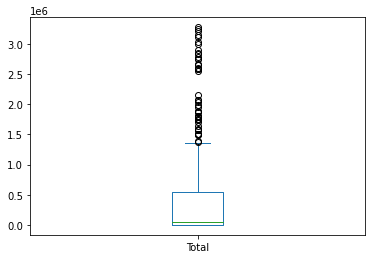

In [23]:
# Análise visual das licitações Ilegais para esta modalidade
lic_obras_RP_2018[lic_obras_RP_2018['Tag'] == 0]['Total'].plot.box()
plt.show()

In [24]:
lic_obras_RP_2018[lic_obras_RP_2018['Tag'] == 0]['Total'].describe()

count    2.900000e+02
mean     5.059668e+05
std      8.412065e+05
min      0.000000e+00
25%      5.924750e+03
50%      5.425898e+04
75%      5.489886e+05
max      3.278397e+06
Name: Total, dtype: float64

<AxesSubplot:>

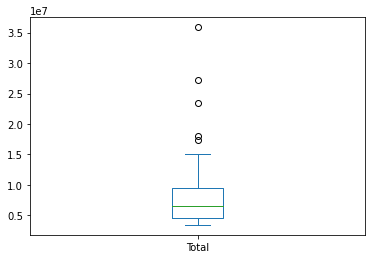

In [25]:
lic_obras_RP_2018[lic_obras_RP_2018['Tag'] == 1]['Total'].plot.box()

In [26]:
lic_compras_RP_2018['Tag'].value_counts()

0    12079
1      256
Name: Tag, dtype: int64

<AxesSubplot:>

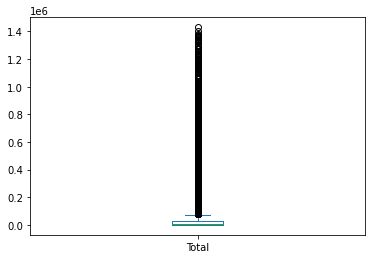

In [27]:
# Visualizando as licitações do tipo Registro de Preço que foram Ilegais
lic_compras_RP_2018[lic_compras_RP_2018['Tag'] == 0]['Total'].plot.box()

In [28]:
lic_compras_RP_2018[lic_compras_RP_2018['Tag'] == 0]['Total'].describe()

count    1.207900e+04
mean     5.315086e+04
std      1.506793e+05
min      0.000000e+00
25%      2.017800e+02
50%      4.312000e+03
75%      3.024000e+04
max      1.429900e+06
Name: Total, dtype: float64

<AxesSubplot:>

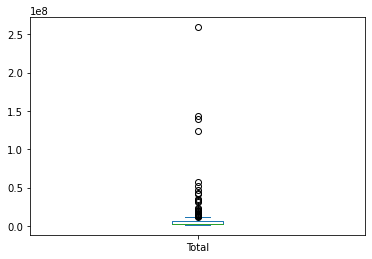

In [29]:
# Visualizando as licitações do tipo Registro de Preço que foram Legais
lic_compras_RP_2018[lic_compras_RP_2018['Tag'] == 1]['Total'].plot.box()

In [30]:
lic_compras_RP_2018[lic_compras_RP_2018['Tag'] == 1]['Total'].describe()

count    2.560000e+02
mean     8.514725e+06
std      2.256791e+07
min      1.433940e+06
25%      2.100683e+06
50%      3.228975e+06
75%      6.024452e+06
max      2.590500e+08
Name: Total, dtype: float64

## Dispensa de Licitação

In [31]:
df_lic_2018_Dispensa = df_lic_2018[df_lic_2018['Modalidade Compra'] == 'Dispensa de Licitação']

In [32]:
df_lic_2018_Dispensa['Modalidade Compra'].value_counts()

Dispensa de Licitação    73521
Name: Modalidade Compra, dtype: int64

In [33]:
df_lic_2018_Dispensa['Tipo'].value_counts()

Compras/Servicos    72157
Obras                1364
Name: Tipo, dtype: int64

In [34]:
lic_obras_Dispensa_2018 = df_lic_2018_Dispensa[df_lic_2018_Dispensa['Tipo'] == 'Obras']
lic_compras_Dispensa_2018 = df_lic_2018_Dispensa[df_lic_2018_Dispensa['Tipo'] != 'Obras']

In [35]:
lic_obras_Dispensa_2018['Tipo'].value_counts()

Obras    1364
Name: Tipo, dtype: int64

In [36]:
lic_compras_Dispensa_2018['Tipo'].value_counts()

Compras/Servicos    72157
Name: Tipo, dtype: int64

## Tag'ando como legal ou ilegal de acordo com Decreto nº 9.412, de 18 de Junho de 2018

#### 0: ilegal
#### 1: legal

In [37]:
lic_obras_Dispensa_2018['Tag'] = 0
lic_compras_Dispensa_2018['Tag'] = 0

C:\Users\lrr\AppData\Local\Temp/ipykernel_13072/474087674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_Dispensa_2018['Tag'] = 0
C:\Users\lrr\AppData\Local\Temp/ipykernel_13072/474087674.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_Dispensa_2018['Tag'] = 0


In [38]:
#regra de limite de valor
lic_obras_Dispensa_2018.loc[lic_obras_Dispensa_2018['Total'] <= 33000 , 'Tag'] = 1
lic_compras_Dispensa_2018.loc[lic_compras_Dispensa_2018['Total'] <= 17600, 'Tag'] = 1

C:\Users\lrr\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [39]:
lic_obras_Dispensa_2018['Tag'].value_counts()

1    1249
0     115
Name: Tag, dtype: int64

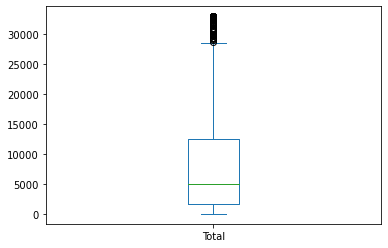

In [40]:
lic_obras_Dispensa_2018[lic_obras_Dispensa_2018['Tag'] == 1]['Total'].plot.box()
plt.show()

In [41]:
lic_obras_Dispensa_2018[lic_obras_Dispensa_2018['Tag'] == 1]['Total'].describe()

count     1249.000000
mean      8238.650376
std       8550.423777
min          0.010000
25%       1705.600000
50%       5000.000000
75%      12500.000000
max      33000.000000
Name: Total, dtype: float64

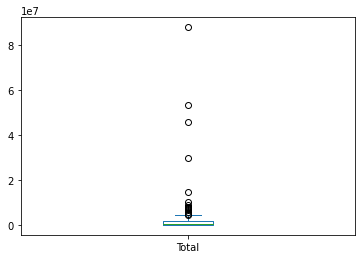

In [42]:
lic_obras_Dispensa_2018[lic_obras_Dispensa_2018['Tag'] == 0]['Total'].plot.box()
plt.show()

In [43]:
lic_obras_Dispensa_2018[lic_obras_Dispensa_2018['Tag'] == 0]['Total'].describe()

count    1.150000e+02
mean     3.321567e+06
std      1.081473e+07
min      3.389529e+04
25%      8.766349e+04
50%      3.619920e+05
75%      1.868894e+06
max      8.794440e+07
Name: Total, dtype: float64

In [44]:
lic_compras_Dispensa_2018['Tag'].value_counts()

1    67597
0     4560
Name: Tag, dtype: int64

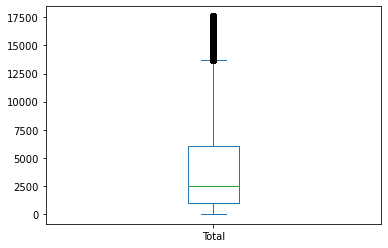

In [45]:
lic_compras_Dispensa_2018[lic_compras_Dispensa_2018['Tag'] == 1]['Total'].plot.box()
plt.show()

In [46]:
lic_compras_Dispensa_2018[lic_compras_Dispensa_2018['Tag'] == 1]['Total'].describe()

count    67597.000000
mean      4188.949777
std       4357.383015
min          0.000000
25%        938.300000
50%       2500.000000
75%       6037.000000
max      17600.000000
Name: Total, dtype: float64

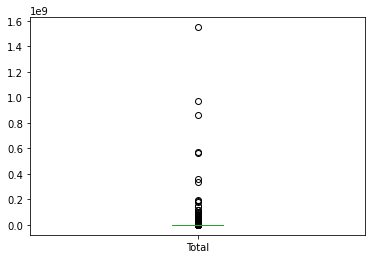

In [47]:
lic_compras_Dispensa_2018[lic_compras_Dispensa_2018['Tag'] == 0]['Total'].plot.box()
plt.show()

In [48]:
lic_compras_Dispensa_2018[lic_compras_Dispensa_2018['Tag'] == 0]['Total'].describe()

count    4.560000e+03
mean     2.480859e+06
std      3.401670e+07
min      1.761433e+04
25%      3.186395e+04
50%      8.358712e+04
75%      4.000000e+05
max      1.549004e+09
Name: Total, dtype: float64

## Tomada de Preço

In [49]:
df_lic_2018_tomada_de_preco = df_lic_2018[df_lic_2018['Modalidade Compra'] == 'Tomada de Preços']

In [50]:
df_lic_2018_tomada_de_preco['Modalidade Compra'].value_counts()

Tomada de Preços    529
Name: Modalidade Compra, dtype: int64

In [51]:
df_lic_2018_tomada_de_preco['Tipo'].value_counts()

Compras/Servicos    330
Obras               199
Name: Tipo, dtype: int64

In [52]:
lic_obras_tomada_de_preco_2018 = df_lic_2018_tomada_de_preco[df_lic_2018_tomada_de_preco['Tipo'] == 'Obras']
lic_compras_tomada_de_preco_2018 = df_lic_2018_tomada_de_preco[df_lic_2018_tomada_de_preco['Tipo'] != 'Obras']

In [53]:
lic_obras_tomada_de_preco_2018['Tipo'].value_counts()

Obras    199
Name: Tipo, dtype: int64

In [54]:
lic_compras_tomada_de_preco_2018['Tipo'].value_counts()

Compras/Servicos    330
Name: Tipo, dtype: int64

In [55]:
## Tag'ando como legal ou ilegal de acordo com Decreto nº 9.412, de 18 de Junho de 2018

#### 0: ilegal
#### 1: legal

lic_obras_tomada_de_preco_2018['Tag'] = 0
lic_compras_tomada_de_preco_2018['Tag'] = 0

#regra de limite de valor
lic_obras_tomada_de_preco_2018.loc[(lic_obras_tomada_de_preco_2018['Total'] >  330000) & (lic_obras_tomada_de_preco_2018['Total'] <=   3300000) , 'Tag'] = 1
lic_compras_tomada_de_preco_2018.loc[(lic_compras_tomada_de_preco_2018['Total'] >  176000) & (lic_compras_tomada_de_preco_2018['Total'] <=  1400000), 'Tag'] = 1

C:\Users\lrr\AppData\Local\Temp/ipykernel_13072/4286322562.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_tomada_de_preco_2018['Tag'] = 0
C:\Users\lrr\AppData\Local\Temp/ipykernel_13072/4286322562.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_tomada_de_preco_2018['Tag'] = 0
C:\Users\lrr\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [56]:
lic_obras_tomada_de_preco_2018['Tag'].value_counts()

1    103
0     96
Name: Tag, dtype: int64

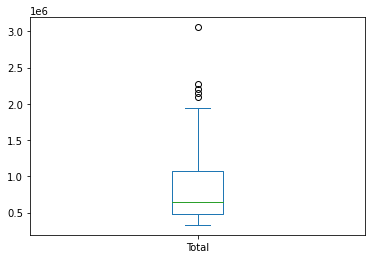

In [57]:
lic_obras_tomada_de_preco_2018[lic_obras_tomada_de_preco_2018['Tag'] == 1]['Total'].plot.box()
plt.show()

In [58]:
lic_obras_tomada_de_preco_2018[lic_obras_tomada_de_preco_2018['Tag'] == 1]['Total'].describe()

count    1.030000e+02
mean     8.388796e+05
std      5.172125e+05
min      3.303021e+05
25%      4.749311e+05
50%      6.453852e+05
75%      1.068229e+06
max      3.056225e+06
Name: Total, dtype: float64

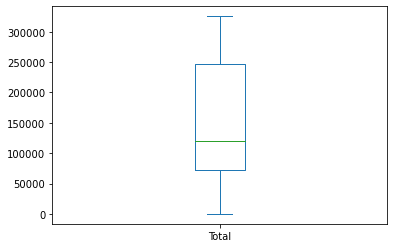

In [59]:
lic_obras_tomada_de_preco_2018[lic_obras_tomada_de_preco_2018['Tag'] == 0]['Total'].plot.box()
plt.show()

In [60]:
lic_compras_tomada_de_preco_2018['Tag'].value_counts()

1    206
0    124
Name: Tag, dtype: int64

In [61]:
# Licitaçoes Legais
lic_compras_tomada_de_preco_2018[lic_compras_tomada_de_preco_2018['Tag'] == 1]['Total'].describe()

count    2.060000e+02
mean     5.268494e+05
std      2.985093e+05
min      1.774304e+05
25%      2.859337e+05
50%      4.371683e+05
75%      7.249722e+05
max      1.339413e+06
Name: Total, dtype: float64

In [62]:
lic_compras_tomada_de_preco_2018[lic_compras_tomada_de_preco_2018['Tag'] == 1]['Total'].describe()

count    2.060000e+02
mean     5.268494e+05
std      2.985093e+05
min      1.774304e+05
25%      2.859337e+05
50%      4.371683e+05
75%      7.249722e+05
max      1.339413e+06
Name: Total, dtype: float64

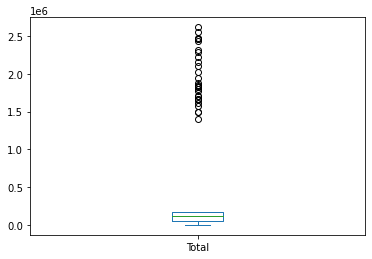

In [63]:
# Licitações Ilegais
lic_compras_tomada_de_preco_2018[lic_compras_tomada_de_preco_2018['Tag'] == 0]['Total'].plot.box()
plt.show()

In [64]:
lic_compras_tomada_de_preco_2018[lic_compras_tomada_de_preco_2018['Tag'] == 0]['Total'].describe()

count    1.240000e+02
mean     5.401918e+05
std      8.263586e+05
min      0.000000e+00
25%      5.674750e+04
50%      1.187668e+05
75%      1.725145e+05
max      2.617185e+06
Name: Total, dtype: float64

## Convite

In [65]:
df_lic_2018_convite = df_lic_2018[df_lic_2018['Modalidade Compra'] == 'Convite']

In [66]:
df_lic_2018_convite['Modalidade Compra'].value_counts()

Convite    96
Name: Modalidade Compra, dtype: int64

In [67]:
df_lic_2018_convite['Tipo'].value_counts()

Compras/Servicos    61
Obras               35
Name: Tipo, dtype: int64

In [68]:
lic_compras_convite_2018 = df_lic_2018_convite[df_lic_2018_convite['Tipo'] != 'Obras']
lic_obras_convite_2018 = df_lic_2018_convite[df_lic_2018_convite['Tipo'] == 'Obras']

In [69]:
lic_compras_convite_2018['Tipo'].value_counts()

Compras/Servicos    61
Name: Tipo, dtype: int64

In [70]:
lic_obras_convite_2018['Tipo'].value_counts()

Obras    35
Name: Tipo, dtype: int64

In [71]:
## Tag'ando como legal ou ilegal de acordo com Decreto nº 9.412, de 18 de Junho de 2018

#### 0: ilegal
#### 1: legal

lic_compras_convite_2018['Tag'] = 0
lic_obras_convite_2018['Tag'] = 0

#regra de limite de valor
lic_compras_convite_2018.loc[(lic_compras_convite_2018['Total'] >  17600) & (lic_compras_convite_2018['Total'] <=   176000) , 'Tag'] = 1
lic_obras_convite_2018.loc[(lic_obras_convite_2018['Total'] >  33000) & (lic_obras_convite_2018['Total'] <=   330000), 'Tag'] = 1


C:\Users\lrr\AppData\Local\Temp/ipykernel_13072/4235792873.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_convite_2018['Tag'] = 0
C:\Users\lrr\AppData\Local\Temp/ipykernel_13072/4235792873.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_convite_2018['Tag'] = 0
C:\Users\lrr\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [72]:
lic_compras_convite_2018['Tag'].value_counts()

1    48
0    13
Name: Tag, dtype: int64

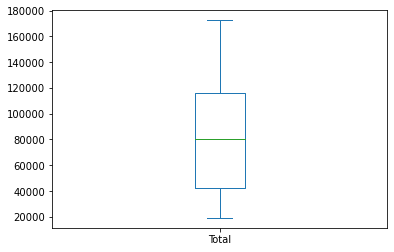

In [73]:
lic_compras_convite_2018[lic_compras_convite_2018['Tag'] == 1]['Total'].plot.box()
plt.show()

In [74]:
lic_compras_convite_2018[lic_compras_convite_2018['Tag'] == 1]['Total'].describe()

count        48.000000
mean      83455.686458
std       41452.060278
min       18999.000000
25%       42039.625000
50%       79978.515000
75%      116000.870000
max      172441.540000
Name: Total, dtype: float64

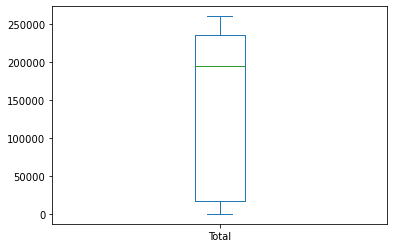

In [75]:
lic_compras_convite_2018[lic_compras_convite_2018['Tag'] == 0]['Total'].plot.box()
plt.show()

In [76]:
lic_compras_convite_2018[lic_compras_convite_2018['Tag'] == 0]['Total'].describe()

count        13.000000
mean     153774.155385
std      102730.401805
min          83.050000
25%       16598.220000
50%      194247.890000
75%      235309.290000
max      259768.320000
Name: Total, dtype: float64

In [77]:
lic_obras_convite_2018['Tag'].value_counts()

1    28
0     7
Name: Tag, dtype: int64

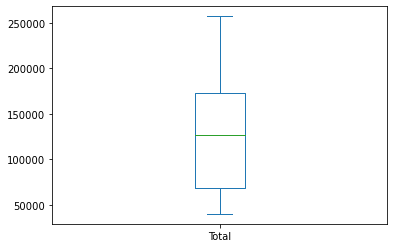

In [78]:
lic_obras_convite_2018[lic_obras_convite_2018['Tag'] == 1]['Total'].plot.box()
plt.show()

In [79]:
lic_obras_convite_2018[lic_obras_convite_2018['Tag'] == 1]['Total'].describe()

count        28.000000
mean     131196.727143
std       66763.710899
min       40088.130000
25%       69023.397500
50%      126214.060000
75%      172744.262500
max      257141.800000
Name: Total, dtype: float64

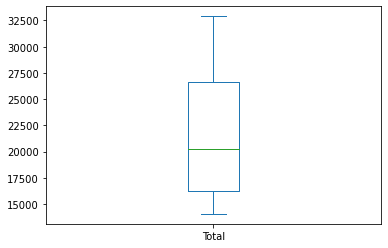

In [80]:
lic_obras_convite_2018[lic_obras_convite_2018['Tag'] == 0]['Total'].plot.box()
plt.show()

In [81]:
lic_obras_convite_2018[lic_obras_convite_2018['Tag'] == 0]['Total'].describe()

count        7.000000
mean     21845.615714
std       7246.367196
min      14053.430000
25%      16276.825000
50%      20230.120000
75%      26588.335000
max      32905.440000
Name: Total, dtype: float64

### As modalidades abaixo não possuem uma regra bem definida para os valores de Licitação. Dessa forma, será atribuido a tag legal como padrão.

## Pregão

In [82]:
df_lic_2018_Pregao = df_lic_2018[df_lic_2018['Modalidade Compra'] == 'Pregão']

In [83]:
df_lic_2018_Pregao['Modalidade Compra'].value_counts()

Pregão    11609
Name: Modalidade Compra, dtype: int64

In [84]:
df_lic_2018_Pregao['Tipo'].value_counts()

Compras/Servicos    10575
Obras                1034
Name: Tipo, dtype: int64

In [85]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_Pregao_2018 = df_lic_2018_Pregao[df_lic_2018_Pregao['Tipo'] == 'Obras']
lic_compras_Pregao_2018 = df_lic_2018_Pregao[df_lic_2018_Pregao['Tipo'] != 'Obras']

In [86]:
lic_obras_Pregao_2018['Tipo'].value_counts()

Obras    1034
Name: Tipo, dtype: int64

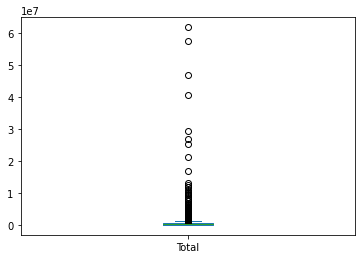

In [87]:
lic_obras_Pregao_2018['Total'].plot.box()
plt.show()

In [88]:
lic_obras_Pregao_2018['Total'].describe()

count    1.034000e+03
mean     9.362342e+05
std      3.897006e+06
min      0.000000e+00
25%      4.602500e+04
50%      1.499049e+05
75%      5.225229e+05
max      6.196085e+07
Name: Total, dtype: float64

In [89]:
lic_compras_Pregao_2018['Tipo'].value_counts()

Compras/Servicos    10575
Name: Tipo, dtype: int64

<AxesSubplot:>

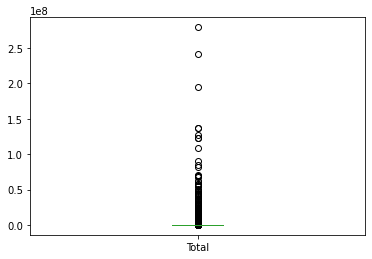

In [90]:
lic_compras_Pregao_2018['Total'].plot.box()

In [91]:
lic_compras_Pregao_2018['Total'].describe()

count    1.057500e+04
mean     7.618533e+05
std      6.131122e+06
min      0.000000e+00
25%      1.260000e+04
50%      4.783383e+04
75%      1.999200e+05
max      2.793588e+08
Name: Total, dtype: float64

In [92]:
## Tag'ando como legal já que não existe uma regra bem definida para a modalidade Pregão

#### 0: ilegal
#### 1: legal
lic_obras_Pregao_2018['Tag'] = 1
lic_compras_Pregao_2018['Tag'] = 1

C:\Users\lrr\AppData\Local\Temp/ipykernel_13072/3567924210.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_Pregao_2018['Tag'] = 1
C:\Users\lrr\AppData\Local\Temp/ipykernel_13072/3567924210.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_Pregao_2018['Tag'] = 1


In [93]:
lic_obras_Pregao_2018['Tag'].value_counts()

1    1034
Name: Tag, dtype: int64

In [94]:
lic_compras_Pregao_2018['Tag'].value_counts()

1    10575
Name: Tag, dtype: int64

## Inexigibilidade de Licitação 

In [95]:
df_lic_2018_Inex_2018 = df_lic_2018[df_lic_2018['Modalidade Compra'] == 'Inexigibilidade de Licitação']

In [96]:
df_lic_2018_Inex_2018['Modalidade Compra'].value_counts()

Inexigibilidade de Licitação    14486
Name: Modalidade Compra, dtype: int64

In [97]:
df_lic_2018_Inex_2018['Tipo'].value_counts()

Compras/Servicos    14161
Obras                 325
Name: Tipo, dtype: int64

In [98]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_Inex_2018 = df_lic_2018_Inex_2018[df_lic_2018_Inex_2018['Tipo'] == 'Obras']
lic_compras_Inex_2018 = df_lic_2018_Inex_2018[df_lic_2018_Inex_2018['Tipo'] != 'Obras']

In [99]:
lic_obras_Inex_2018['Tipo'].value_counts()

Obras    325
Name: Tipo, dtype: int64

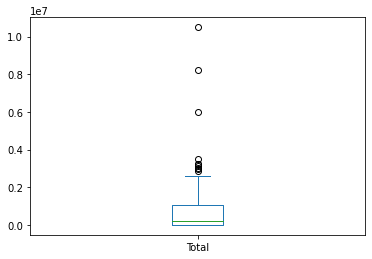

In [100]:
lic_obras_Inex_2018['Total'].plot.box()
plt.show()

In [101]:
lic_obras_Inex_2018['Total'].describe()

count    3.250000e+02
mean     6.565760e+05
std      1.050316e+06
min      1.000000e-02
25%      4.000000e+03
50%      2.152793e+05
75%      1.077328e+06
max      1.050000e+07
Name: Total, dtype: float64

In [102]:
lic_compras_Inex_2018['Tipo'].value_counts()

Compras/Servicos    14161
Name: Tipo, dtype: int64

<AxesSubplot:>

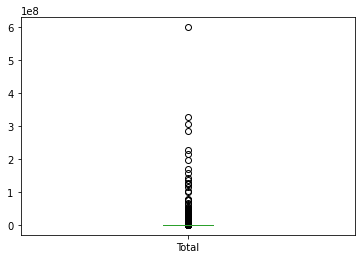

In [103]:
lic_compras_Inex_2018['Total'].plot.box()

In [104]:
lic_compras_Inex_2018['Total'].describe()

count    1.416100e+04
mean     5.357749e+05
std      8.584033e+06
min      1.000000e-02
25%      1.428000e+03
50%      5.000000e+03
75%      2.676932e+04
max      5.987247e+08
Name: Total, dtype: float64

In [105]:
## Tag'ando como legal já que não existe uma regra bem definida para esta modalidade

#### 0: ilegal
#### 1: legal
lic_obras_Inex_2018['Tag'] = 1
lic_compras_Inex_2018['Tag'] = 1

C:\Users\lrr\AppData\Local\Temp/ipykernel_13072/1411772937.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_Inex_2018['Tag'] = 1
C:\Users\lrr\AppData\Local\Temp/ipykernel_13072/1411772937.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_Inex_2018['Tag'] = 1


In [106]:
lic_obras_Inex_2018['Tag'].value_counts()

1    325
Name: Tag, dtype: int64

In [107]:
lic_compras_Inex_2018['Tag'].value_counts()

1    14161
Name: Tag, dtype: int64

## Concurso

In [108]:
df_lic_2018_concurso = df_lic_2018[df_lic_2018['Modalidade Compra'] == 'Concurso']

In [109]:
df_lic_2018_concurso['Modalidade Compra'].value_counts()

Concurso    18
Name: Modalidade Compra, dtype: int64

In [110]:
df_lic_2018_concurso['Tipo'].value_counts()

Compras/Servicos    17
Obras                1
Name: Tipo, dtype: int64

In [111]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_concurso_2018 = df_lic_2018_concurso[df_lic_2018_concurso['Tipo'] == 'Obras']
lic_compras_concurso_2018 = df_lic_2018_concurso[df_lic_2018_concurso['Tipo'] != 'Obras']

In [112]:
lic_obras_concurso_2018['Tipo'].value_counts()

Obras    1
Name: Tipo, dtype: int64

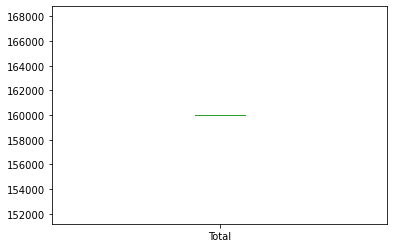

In [113]:
lic_obras_concurso_2018['Total'].plot.box()
plt.show()

<AxesSubplot:>

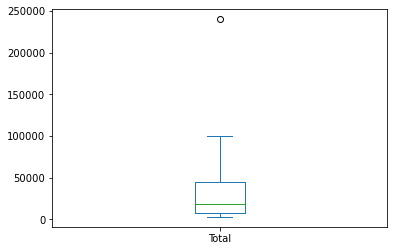

In [114]:
lic_compras_concurso_2018['Total'].plot.box()

In [115]:
lic_compras_concurso_2018['Total'].describe()

count        17.000000
mean      39690.588235
std       58088.484279
min        3000.000000
25%        8000.000000
50%       18000.000000
75%       45000.000000
max      240000.000000
Name: Total, dtype: float64

In [116]:
## Tag'ando como legal já que não existe uma regra bem definida para esta modalidade

#### 0: ilegal
#### 1: legal
lic_obras_concurso_2018['Tag'] = 1
lic_compras_concurso_2018['Tag'] = 1

C:\Users\lrr\AppData\Local\Temp/ipykernel_13072/3505025051.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_concurso_2018['Tag'] = 1
C:\Users\lrr\AppData\Local\Temp/ipykernel_13072/3505025051.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_concurso_2018['Tag'] = 1


In [117]:
lic_obras_concurso_2018['Tag'].value_counts()

1    1
Name: Tag, dtype: int64

In [118]:
lic_compras_concurso_2018['Tag'].value_counts()

1    17
Name: Tag, dtype: int64

### Concorrência Internacional

In [119]:
df_lic_2018_concorrencia_internacional = df_lic_2018[df_lic_2018['Modalidade Compra'] == 'Concorrência Internacional']

In [120]:
df_lic_2018_concorrencia_internacional['Modalidade Compra'].value_counts()

Concorrência Internacional    11
Name: Modalidade Compra, dtype: int64

In [121]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_concorrencia_internacional_2018 = df_lic_2018_concorrencia_internacional[df_lic_2018_concorrencia_internacional['Tipo'] == 'Obras']
lic_compras_concorrencia_internacional_2018 = df_lic_2018_concorrencia_internacional[df_lic_2018_concorrencia_internacional['Tipo'] != 'Obras']

In [122]:
lic_obras_concorrencia_internacional_2018['Tipo'].value_counts()

Series([], Name: Tipo, dtype: int64)

In [123]:
lic_compras_concorrencia_internacional_2018['Tipo'].value_counts()

Compras/Servicos    11
Name: Tipo, dtype: int64

<AxesSubplot:>

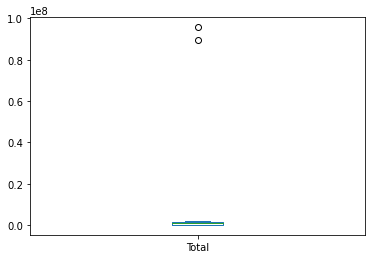

In [124]:
lic_compras_concorrencia_internacional_2018['Total'].plot.box()

In [125]:
lic_compras_concorrencia_internacional_2018['Total'].describe()

count    1.100000e+01
mean     1.733756e+07
std      3.722459e+07
min      6.688142e+04
25%      1.440911e+05
50%      8.882944e+05
75%      1.442972e+06
max      9.574421e+07
Name: Total, dtype: float64

In [126]:
## Tag'ando como legal já que não existe uma regra bem definida para esta modalidade

#### 0: ilegal
#### 1: legal
lic_obras_concorrencia_internacional_2018['Tag'] = 1
lic_compras_concorrencia_internacional_2018['Tag'] = 1

In [127]:
lic_obras_concorrencia_internacional_2018['Tag'].value_counts()

Series([], Name: Tag, dtype: int64)

In [128]:
lic_compras_concorrencia_internacional_2018['Tag'].value_counts()

1    11
Name: Tag, dtype: int64

### Salvando todas as analises em uma única base de dados.

In [129]:
lic_2018_com_tag = pd.concat([lic_obras_RP_2018, lic_compras_RP_2018, lic_obras_Dispensa_2018, lic_compras_Dispensa_2018, lic_obras_tomada_de_preco_2018, lic_compras_tomada_de_preco_2018, lic_compras_convite_2018, lic_obras_convite_2018, lic_obras_Pregao_2018, lic_compras_Pregao_2018, lic_obras_Inex_2018, lic_compras_Inex_2018, lic_obras_concurso_2018, lic_compras_concurso_2018, lic_obras_concorrencia_internacional_2018, lic_compras_concorrencia_internacional_2018])

In [131]:
lic_2018_com_tag.to_csv('lic_2018_com_tag.csv')

In [132]:
lic_2018_com_tag['Tag'].value_counts()

1    95652
0    17284
Name: Tag, dtype: int64

In [133]:
lic_2018_com_tag.groupby(['Modalidade Compra','Tag', 'Tipo']).describe()

Número Licitação  \
                                                                 count   
Modalidade Compra                Tag Tipo                                
Concorrência                     0   Compras/Servicos             60.0   
                                     Obras                        76.0   
                                 1   Compras/Servicos             60.0   
                                     Obras                        29.0   
Concorrência - Registro de Preço 0   Compras/Servicos              5.0   
Concorrência Internacional       1   Compras/Servicos             11.0   
Concurso                         1   Compras/Servicos             17.0   
                                     Obras                         1.0   
Convite                          0   Compras/Servicos             13.0   
                                     Obras                         7.0   
                                 1   Compras/Servicos             48.0   
                                     Obras                        28.0   
Dispensa de Licitação            0   Compras/Servicos           4560.0   
                                     Obras                       115.0   
                                 1   Compras/Servicos          67597.0   
                                     Obras                      1249.0   
Inexigibilidade de Licitação     1   Compras/Servicos          14161.0   
                                     Obras                       325.0   
Pregão                           1   Compras/Servicos          10575.0   
                                     Obras                      1034.0   
Pregão - Registro de Preço       0   Compras/Servicos          12014.0   
                                     Obras                       214.0   
                                 1   Compras/Servicos            196.0   
                                     Obras                        12.0   
Tomada de Preços                 0   Compras/Servicos            124.0   
                                     Obras                        96.0   
                                 1   Compras/Servicos            206.0   
                                     Obras                       103.0   

                                                                     \
                                                               mean   
Modalidade Compra                Tag Tipo                             
Concorrência                     0   Compras/Servicos  1.931845e+05   
                                     Obras             5.517587e+04   
                                 1   Compras/Servicos  7.603851e+06   
                                     Obras             3.339714e+04   
Concorrência - Registro de Preço 0   Compras/Servicos  6.601800e+04   
Concorrência Internacional       1   Compras/Servicos  1.857472e+06   
Concurso                         1   Compras/Servicos  2.731206e+04   
                                     Obras             3.201700e+04   
Convite                          0   Compras/Servicos  1.552018e+06   
                                     Obras             2.773229e+04   
                                 1   Compras/Servicos  3.659763e+05   
                                     Obras             1.638037e+05   
Dispensa de Licitação            0   Compras/Servicos  2.118900e+07   
                                     Obras             1.446384e+07   
                                 1   Compras/Servicos  2.071706e+07   
                                     Obras             6.186005e+06   
Inexigibilidade de Licitação     1   Compras/Servicos  1.126313e+07   
                                     Obras             3.910264e+06   
Pregão                           1   Compras/Servicos  7.938788e+06   
                                     Obras             5.624242e+06   
Pregão - Registro de Preço       0   Compras/Servicos  1.831750e+06   
                                     Obras             